# Overview
 
- Initial Steps
- Baseline (Ratings)
- Baseline+ (Ratings + Genre)
- Baseline++ (Ratings + Genre + Subgenre)

This is the Jupyter Notebook where the thought process behind and implementation of the recommender system is done. Baseline++ is our proposed model, where subgenres of movies are artificially generated by Gaussian Mixture Models using the scripts of the same movies.

## Initial Steps

First, it'll be necessary to parse through the MovieLens dataset and extract some dictionaries/mappings that we'll need.

We need a mapping from movie IDs to the movie name as well as a mapping from the movie IDs to their genres.

In [11]:
import pandas as pd
import numpy as np
import math
import pickle
from tqdm import tqdm_notebook as tqdm

In [12]:
col = ['id', 'name', 'release_date', 'useless', 'useless1', 'useless2', 'Action', 'Adventure', 'Animation',
              'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
            'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

item_df = pd.read_csv("ml-100k/u.item", sep='|', encoding='latin-1', names=col, header=None)
item_df = item_df.drop(['release_date', 'useless', 'useless1', 'useless2'], axis=1)

id_to_name_dict = {}
id_to_genre_dict = {}
for index, row in item_df.iterrows():
    name = row['name']
    name = name.split("(")[0].strip()
    id_to_name_dict[name] = row['id']
    
    genre = []
    
    if row['Action'] == 1:
        genre.append(0)
    if row['Adventure'] == 1:
        genre.append(1)
    if row['Animation'] == 1:
        genre.append(2)
    if row['Children\'s'] == 1:
        genre.append(3)
    if row['Comedy'] == 1:
        genre.append(4)
    if row['Crime'] == 1:
        genre.append(5)
    if row['Documentary'] == 1:
        genre.append(6)
    if row['Drama'] == 1:
        genre.append(7)
    if row['Fantasy'] == 1:
        genre.append(8)
    if row['Film-Noir'] == 1:
        genre.append(9)
    if row['Horror'] == 1:
        genre.append(10)
    if row['Musical'] == 1:
        genre.append(11)
    if row['Mystery'] == 1:
        genre.append(12)
    if row['Romance'] == 1:
        genre.append(13)
    if row['Sci-Fi'] == 1:
        genre.append(14)
    if row['Thriller'] == 1:
        genre.append(15)
    if row['War'] == 1:
        genre.append(16)
    if row['Western'] == 1:
        genre.append(17)
        
    id_to_genre_dict[row['id']] = genre

In [13]:
with open("id_name_dict.pickle", "wb") as output_pickle:
    pickle.dump(id_to_name_dict, output_pickle)
    
with open("id_to_genre_dict.pickle", "wb") as output_pickle:
    pickle.dump(id_to_genre_dict, output_pickle)

We also need a mapping of the genre to the movie IDs of the same genre

In [14]:
item_df.drop(['name'], axis=1)
genre_ids = [[], [], [], [], [], [], [], [], [], [], [] ,[] ,[] ,[] ,[] ,[] ,[] ,[]]
for index, row in item_df.iterrows():
    name = row['id']
    id_to_name_dict[name] = row['id']
    
    genre = []
    
    if row['Action'] == 1:
        genre_ids[0].append(name)
    if row['Adventure'] == 1:
        genre_ids[1].append(name)
    if row['Animation'] == 1:
        genre_ids[2].append(name)
    if row['Children\'s'] == 1:
        genre_ids[3].append(name)
    if row['Comedy'] == 1:
        genre_ids[4].append(name)
    if row['Crime'] == 1:
        genre_ids[5].append(name)
    if row['Documentary'] == 1:
        genre_ids[6].append(name)
    if row['Drama'] == 1:
        genre_ids[7].append(name)
    if row['Fantasy'] == 1:
        genre_ids[8].append(name)
    if row['Film-Noir'] == 1:
        genre_ids[9].append(name)
    if row['Horror'] == 1:
        genre_ids[10].append(name)
    if row['Musical'] == 1:
        genre_ids[11].append(name)
    if row['Mystery'] == 1:
        genre_ids[12].append(name)
    if row['Romance'] == 1:
        genre_ids[13].append(name)
    if row['Sci-Fi'] == 1:
        genre_ids[14].append(name)
    if row['Thriller'] == 1:
        genre_ids[15].append(name)
    if row['War'] == 1:
        genre_ids[16].append(name)
    if row['Western'] == 1:
        genre_ids[17].append(name)

with open("genre_ids.pickle", "wb") as output_pickle:
    pickle.dump(genre_ids, output_pickle)

## Baseline

First, let's establish a baseline where we perform collaborative filtering using just cosine similarity of rating of the movies by users. We take our MovieLens dataset and eliminate all of the movies where we don't have scripts (to maintain consistency of the amount of training data between models).

In [15]:
def in_dataset(row):
    if row['item_id'] in scripts_id_dict:
        return True
    else:
        return False

with open("scripts_id_content.pickle", "rb") as output_pickle:
    scripts_id_dict = pickle.load(output_pickle)
    
    col = ['user_id', 'item_id', 'rating', 'timestamp']
    df = pd.read_csv("ml-100k/u.data", names=col, sep='\t', header=None, encoding='latin-1')
    df['in_dataset'] = df.apply(lambda row: in_dataset(row), axis=1)
    df = df[df['in_dataset'] == True]
    df = df.drop(['in_dataset'], axis=1)
    

Spliting into an 80/20 train-test split and normalize by subtracting the mean from each rating

In [17]:
ratings_training = df.sample(frac=0.8)
ratings_test = df.drop(ratings_training.index)

rating_mean = ratings_training.groupby(['item_id'], as_index = False, sort = False).mean().rename(columns = {'rating': 'rating_mean'})[['item_id','rating_mean']]
adjusted_ratings = pd.merge(ratings_training, rating_mean,on = 'item_id', how = 'left', sort = False)
adjusted_ratings['rating_adjusted'] = adjusted_ratings['rating'] - adjusted_ratings['rating_mean']
#replace 0 adjusted rating values to 1*e-8 in order to avoid 0 denominator
adjusted_ratings.loc[adjusted_ratings['rating_adjusted'] == 0, 'rating_adjusted'] = 1e-8

Then we start building the similarity matrix by iterating through every user and then every movie they've watched and calculating similarity values between the two (to be put in the weight column). 

In [18]:
def build_w_matrix(adjusted_ratings):
    
    w_matrix_columns = ['movie_a', 'movie_b', 'weight']
    w_matrix = pd.DataFrame(columns=w_matrix_columns)
    
    distinct_movies = np.unique(adjusted_ratings['item_id'])
    
    i = 0
    
    for movie_a in distinct_movies:
        
        if i%2==0:
            print(i , "out of ", len(distinct_movies))
        
        user_data = adjusted_ratings[adjusted_ratings['item_id'] == movie_a]
        distinct_users = np.unique(user_data['user_id'])
        
        record_row_columns = ['user_id', 'movie_a', 'movie_b', 'rating_adjusted_a', 'rating_adjusted_b']
        record_movie_a_b = pd.DataFrame(columns=record_row_columns)
        
        for c_user_id in distinct_users:
            c_movie_a_rating = user_data[user_data['user_id'] == c_user_id]['rating_adjusted'].iloc[0]
            c_user_data = adjusted_ratings[(adjusted_ratings['user_id'] == c_user_id) & (adjusted_ratings['item_id'] != movie_a)]
            c_distinct_movies = np.unique(c_user_data['item_id'])
            
            for movie_b in c_distinct_movies:
                c_movie_b_rating = c_user_data[c_user_data['item_id'] == movie_b]['rating_adjusted'].iloc[0]
                record_row = pd.Series([c_user_id, movie_a, movie_b, c_movie_a_rating, c_movie_b_rating], index=record_row_columns)
                record_movie_a_b = record_movie_a_b.append(record_row, ignore_index=True)
                
        distinct_movie_b = np.unique(record_movie_a_b['movie_b'])
        
        for movie_b in distinct_movie_b:
            paired_movie_a_b = record_movie_a_b[record_movie_a_b['movie_b'] == movie_b]
            
            sim_value_numerator = (paired_movie_a_b['rating_adjusted_a'] * paired_movie_a_b['rating_adjusted_b']).sum()
            sim_value_denominator = np.sqrt(np.square(paired_movie_a_b['rating_adjusted_a']).sum()) * np.sqrt(np.square(paired_movie_a_b['rating_adjusted_b']).sum())
            sim_value_denominator = sim_value_denominator if sim_value_denominator != 0 else 1e-8
            sim_value = sim_value_numerator / sim_value_denominator
            w_matrix = w_matrix.append(pd.Series([movie_a, movie_b, sim_value], index=w_matrix_columns), ignore_index=True)
        i += 1
        
    with open("w_matrix.pickle", 'wb') as output:
        pickle.dump(w_matrix, output, pickle.HIGHEST_PROTOCOL)
    output.close()
        
    return w_matrix
                

In [19]:
w_matrix = build_w_matrix(adjusted_ratings)

0 out of  243
2 out of  243
4 out of  243
6 out of  243
8 out of  243
10 out of  243
12 out of  243
14 out of  243
16 out of  243
18 out of  243
20 out of  243
22 out of  243
24 out of  243
26 out of  243
28 out of  243
30 out of  243
32 out of  243
34 out of  243
36 out of  243
38 out of  243
40 out of  243
42 out of  243
44 out of  243
46 out of  243
48 out of  243
50 out of  243
52 out of  243
54 out of  243
56 out of  243
58 out of  243
60 out of  243
62 out of  243
64 out of  243
66 out of  243
68 out of  243
70 out of  243
72 out of  243
74 out of  243
76 out of  243
78 out of  243
80 out of  243
82 out of  243
84 out of  243
86 out of  243
88 out of  243
90 out of  243
92 out of  243
94 out of  243
96 out of  243
98 out of  243
100 out of  243
102 out of  243
104 out of  243
106 out of  243
108 out of  243
110 out of  243
112 out of  243
114 out of  243
116 out of  243
118 out of  243
120 out of  243
122 out of  243
124 out of  243
126 out of  243
128 out of  243
130 out of  243

Now we create two functions to have our recommender system predict/recommend and be evaluated by converting the ratings to negative and positive and predicting ratings to see if they fall within those two categories. 

Note: 

Precision: percentage of all results that are relevant (false positives, recommends movie when it shouldn't, in denominator)
Recall: percentage of all relevant results correctly classified (false negatives, doesn't recommend movie when it should, in denominator)

We would value precision more in this case since the benefits of making a correct recommendation to a user is much more substantial than the harms of not making a recommendation that it should, especially since a false positive could potentially ward users away

In [20]:
def predict(user_id, item_id, w_matrix, adjusted_ratings, rating_mean):
    if rating_mean[rating_mean['item_id'] == item_id].shape[0] > 0:
        mean_rating = rating_mean[rating_mean['item_id'] == item_id]['rating_mean'].iloc[0]
    else:
        mean_rating = 2.5

    user_other_ratings = adjusted_ratings[adjusted_ratings['user_id'] == user_id]
    user_distinct_movies = np.unique(user_other_ratings['item_id'])
    sum_weighted_other_ratings = 0
    sum_weights = 0
    for movie_j in user_distinct_movies:
        if rating_mean[rating_mean['item_id'] == movie_j].shape[0] > 0:
            rating_mean_j = rating_mean[rating_mean['item_id'] == movie_j]['rating_mean'].iloc[0]
        else:
            rating_mean_j = 2.5
        w_movie_a_b = w_matrix[(w_matrix['movie_a'] == item_id) & (w_matrix['movie_b'] == movie_j)]
        if w_movie_a_b.shape[0] > 0:
            user_rating_j = user_other_ratings[user_other_ratings['item_id']==movie_j]
            sum_weighted_other_ratings += (user_rating_j['rating'].iloc[0] - rating_mean_j) * w_movie_a_b['weight'].iloc[0]
            sum_weights += np.abs(w_movie_a_b['weight'].iloc[0])

    # if sum_weights is 0 (which may be because of no ratings from new users), use the mean ratings
    if sum_weights == 0:
        predicted_rating = mean_rating
    # sum_weights is bigger than 0
    else:
        predicted_rating = mean_rating + sum_weighted_other_ratings/sum_weights

    return predicted_rating

def binary_eval(ratings_test, w_matrix, adjusted_ratings, rating_mean):
    # predict all the ratings for test data
    ratings_test = ratings_test.assign(predicted_rating = pd.Series(np.zeros(ratings_test.shape[0])))
    curr = 0
    for index, row_rating in ratings_test.iterrows():
        if curr % 200 == 0:
            print(curr , "out of ", len(ratings_test))
        predicted_rating = predict(row_rating['user_id'], row_rating['item_id'], w_matrix, adjusted_ratings, rating_mean)
        ratings_test.loc[index, 'predicted_rating'] = predicted_rating
        curr += 1
    tp = ratings_test.query('(rating >= 2.5) & (predicted_rating >= 2.5)').shape[0]
    fp = ratings_test.query('(rating < 2.5) & (predicted_rating >= 2.5)').shape[0]
    fn = ratings_test.query('(rating >= 2.5) & (predicted_rating < 2.5)').shape[0]

    # calculate the precision and recall
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    return (precision, recall)


In [48]:
eval_result = binary_eval(ratings_test, w_matrix, adjusted_ratings, rating_mean)
print('Evaluation result - precision: %f, recall: %f' % eval_result)


0 out of  7070
200 out of  7070
400 out of  7070
600 out of  7070
800 out of  7070
1000 out of  7070
1200 out of  7070
1400 out of  7070
1600 out of  7070
1800 out of  7070
2000 out of  7070
2200 out of  7070
2400 out of  7070
2600 out of  7070
2800 out of  7070
3000 out of  7070
3200 out of  7070
3400 out of  7070
3600 out of  7070
3800 out of  7070
4000 out of  7070
4200 out of  7070
4400 out of  7070
4600 out of  7070
4800 out of  7070
5000 out of  7070
5200 out of  7070
5400 out of  7070
5600 out of  7070
5800 out of  7070
6000 out of  7070
6200 out of  7070
6400 out of  7070
6600 out of  7070
6800 out of  7070
7000 out of  7070
Evaluation result - precision: 0.877292, recall: 0.988773


## Baseline+ 

We can improve upon these metrics by incorporating the genre of movies into our similarity matrix. For every given similarity value, if the two movies are of the same genre, then the similarity value will be multipled by a number greater than 1 (increased). 

Note: This factor needs to be fiddled around with to find an optimal value. Future steps include a grid search for an idea value but initial checks seem to indicate that a value between 1 and 2 is ideal. Below we use 1.4

In [86]:
with open("id_genre_dict.pickle", "rb") as output_pickle:
    id_to_genre_dict = pickle.load(output_pickle)

In [87]:
def adjust_w_matrix_by_genre(w_matrix, genre_dict, factor=1.2):
    adjusted_w_matrix = w_matrix.copy()
    
    for index, row in w_matrix.iterrows():
        a_genres = genre_dict[int(row['movie_a'])]
        b_genres = genre_dict[int(row['movie_b'])]
        if not set(a_genres).isdisjoint(b_genres): #if there is overlap, this is true
            adjusted_w_matrix.set_value(index, 'weight', row['weight']*factor)
    
    return adjusted_w_matrix

In [88]:
genre_dict = id_to_genre_dict
w_matrix_genres = adjust_w_matrix_by_genre(w_matrix, genre_dict, 1.4)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [89]:
# run the evaluation
eval_result = binary_eval(ratings_test, w_matrix_genres, adjusted_ratings, rating_mean)
print('Evaluation result - precision: %f, recall: %f' % eval_result)

0 out of  7070
200 out of  7070
400 out of  7070
600 out of  7070
800 out of  7070
1000 out of  7070
1200 out of  7070
1400 out of  7070
1600 out of  7070
1800 out of  7070
2000 out of  7070
2200 out of  7070
2400 out of  7070
2600 out of  7070
2800 out of  7070
3000 out of  7070
3200 out of  7070
3400 out of  7070
3600 out of  7070
3800 out of  7070
4000 out of  7070
4200 out of  7070
4400 out of  7070
4600 out of  7070
4800 out of  7070
5000 out of  7070
5200 out of  7070
5400 out of  7070
5600 out of  7070
5800 out of  7070
6000 out of  7070
6200 out of  7070
6400 out of  7070
6600 out of  7070
6800 out of  7070
7000 out of  7070
Evaluation result - precision: 0.881028, recall: 0.986821


## Baseline++

Here is where the subgenres are incorporated. The idea is similar to that of Baseline+: if two movies are in the same subgenre, then they should be considered more similar. 

However, these subgenres are not easily obtained: most movies are just broadly labeled into categories such as "drama," "comedy," or "horror." However, there are many distinctions within each of those categories that would make recommendation based solely on those categorizations faulty.

One way to obtain these subgenres is to analyze the scripts of each movie. Each word will be converted into a 300 length vector through a pretrained FastText model. FastText is a model that trains on corpora (the one used was trained on Wikipedia) and then uses an n-gram model to creates word embeddings. 

In [65]:
from nltk.tokenize import word_tokenize
import re
import string

In [66]:
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

To reduce time complexity, we'll first create a list of all unique words in the dataset before creating a word-to-vector mapping

In [67]:
unique_words = set()
with open("scripts_new.csv", "r") as f:
    scripts = f.readlines()
    for single in scripts:
        single = single.split("|")[1]
        single = cleanhtml(single).lower()
        single = single.translate(str.maketrans('', '', string.punctuation))

        for word in word_tokenize(single):
            unique_words.add(word)

In [68]:
with open("vocab.txt", "w") as f:
    for word in unique_words:
        f.write(word + "\n")
        

Here, the vocab.txt file was sent through the FastText bin file on a separate machine due to the size of the model.

In [69]:
vector_dict = {}

with open("dict.txt", "r") as f:
    lines = f.readlines()
    for line in tqdm(lines):
        word = line.split(" ")[0]
        vector = line.split(" ")[1:][:-1]
        assert len(vector) == 300
        
        if word not in vector_dict:
            vector_list = []
            for num in vector:
                vector_list.append(float(num))
                
            vector_dict[word] = vector_list

In [70]:
scripts_content = {}
with open("scripts_new.csv", "r") as f:
    scripts = f.readlines()
    for single_index in tqdm(range(len(scripts))):
        single = scripts[single_index]
        title = single.split("|")[0]
        single = single.split("|")[1]
        single = cleanhtml(single).lower()
        single = single.translate(str.maketrans('', '', string.punctuation))
        
        content = []
        
        for word in word_tokenize(single):
            try:
                content.append(vector_dict[word])
            except:
                pass
        
        if title not in scripts_content:
            scripts_content[title] = content

with open("scripts_vector_dict.pickle", "wb") as output_pickle:
    pickle.dump(scripts_content, output_pickle)

In [71]:
id_scripts_content = {}
id_genre_dict = id_to_genre_dict
id_name_dict = id_to_name_dict

for movie_name in list(scripts_content.keys()):
    if movie_name in id_name_dict:
        id_scripts_content[id_name_dict[movie_name]] = scripts_content[movie_name]

genre_dist = []
for movie_id in id_scripts_content:
    if movie_id in id_genre_dict:
        for label in id_genre_dict[movie_id]:
            genre_dist.append(label)

Below is the distribution of our scripts, which we use to inform our N value for our Gaussian Mixture Models (another hyperparameter that needs a grid search):

(array([68, 25,  7, 10, 61, 28,  0, 95,  2,  8, 23,  9, 20, 41, 32, 72, 14,
        3]), array([ 0.        ,  0.94444444,  1.88888889,  2.83333333,  3.77777778,
        4.72222222,  5.66666667,  6.61111111,  7.55555556,  8.5       ,
        9.44444444, 10.38888889, 11.33333333, 12.27777778, 13.22222222,
       14.16666667, 15.11111111, 16.05555556, 17.        ]))


(array([68., 25.,  7., 10., 61., 28.,  0., 95.,  2.,  8., 23.,  9., 20.,
        41., 32., 72., 14.,  3.]),
 array([ 0.        ,  0.94444444,  1.88888889,  2.83333333,  3.77777778,
         4.72222222,  5.66666667,  6.61111111,  7.55555556,  8.5       ,
         9.44444444, 10.38888889, 11.33333333, 12.27777778, 13.22222222,
        14.16666667, 15.11111111, 16.05555556, 17.        ]),
 <a list of 18 Patch objects>)

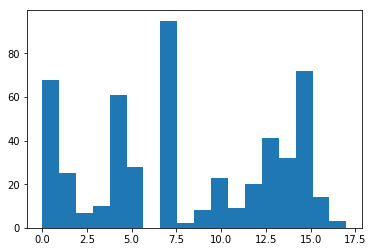

In [72]:
print(np.histogram(genre_dist, bins=18))
import matplotlib.pyplot as plt
plt.hist(genre_dist, bins=18)

In [73]:
plt.show()

In [74]:
with open("scripts_id_content.pickle", "wb") as output_pickle:
    pickle.dump(id_scripts_content, output_pickle)

In [84]:
for key, value in genre_dict.items():
    doublet = [value, {}]
    genre_dict[key] = doublet

In [76]:
from sklearn.mixture import GaussianMixture
all_n = [5, 3, 1, 1, 5, 3, 1, 5, 1, 1, 3, 1, 3, 3, 3, 5, 1, 1]

for genre in range(18):
    
    N = all_n[genre]
    
    genre_data = []
    genre_just_content = []
    
    for movie_id_index in tqdm(range(len(genre_ids[genre]))):
        movie_id = genre_ids[genre][movie_id_index]
        if movie_id in id_scripts_content:
            genre_data.append((movie_id, id_scripts_content[movie_id]))
            genre_just_content.append(id_scripts_content[movie_id])
        
    averaged_array = []

    for movie in genre_just_content:
        if len(movie) > 0:
            averaged_array.append(np.mean(np.asarray(movie), axis=0).tolist())

    if len(averaged_array) > N:
        gmm = GaussianMixture(n_components=N)
        predicted_subclasses = gmm.fit_predict(averaged_array)

        movies_with_subclasses = []

        for index in range(len(genre_data)-1):
            movie = genre_data[index]
            doublet = (movie[0], predicted_subclasses[index])
            movies_with_subclasses.append(doublet)

        for doublet in movies_with_subclasses:
            if doublet[0] in genre_dict:
                genre_dict[doublet[0]][1][doublet[0]] = doublet[1]
    
with open("id_to_genre_with_subgenres_dict.pickle", "wb") as output_pickle:
    pickle.dump(genre_dict, output_pickle)

Now that we have the subgenres all calculated, we adjust the similarity matrix once again.

In [77]:
def adjust_w_matrix_by_subgenre(w_matrix, genre_dict, factor=2):
    adjusted_w_matrix = w_matrix.copy()
    for index, row in w_matrix.iterrows():
        a_genres = genre_dict[int(row['movie_a'])]
        b_genres = genre_dict[int(row['movie_b'])]
        intersect = set(a_genres[0]).intersection(set(b_genres[0]))
        if len(intersect) > 0:
            flag = False
            for genre in intersect:
                if genre in a_genres[1] and genre in b_genres[1]:
                    if a_genres[1][genre] == b_genres[1][genre]:
                        flag = True
            if flag == True:
                adjusted_w_matrix.set_value(index, 'weight', row['weight']*factor)
            
    return adjusted_w_matrix

In [85]:
with open("id_to_genre_with_subgenres_dict.pickle", "wb") as output_pickle:
    pickle.dump(genre_dict, output_pickle)

w_matrix_subgenres = adjust_w_matrix_by_subgenre(w_matrix_genres, genre_dict, 1.1)

# run the evaluation
eval_result = binary_eval(ratings_test, w_matrix_subgenres, adjusted_ratings, rating_mean)
print('Evaluation result - precision: %f, recall: %f' % eval_result)

0 out of  7070
200 out of  7070
400 out of  7070
600 out of  7070
800 out of  7070
1000 out of  7070
1200 out of  7070
1400 out of  7070
1600 out of  7070
1800 out of  7070
2000 out of  7070
2200 out of  7070
2400 out of  7070
2600 out of  7070
2800 out of  7070
3000 out of  7070
3200 out of  7070
3400 out of  7070
3600 out of  7070
3800 out of  7070
4000 out of  7070
4200 out of  7070
4400 out of  7070
4600 out of  7070
4800 out of  7070
5000 out of  7070
5200 out of  7070
5400 out of  7070
5600 out of  7070
5800 out of  7070
6000 out of  7070
6200 out of  7070
6400 out of  7070
6600 out of  7070
6800 out of  7070
7000 out of  7070
Evaluation result - precision: 0.881413, recall: 0.986821
